In [1]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner

from scipy.interpolate import make_interp_spline, BSpline

from tqdm.auto import trange, tqdm

"""from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersiZc
from gigalens.tf.profiles.mass import epl, shear"""

sns.set_style("whitegrid")
tfd = tfp.distributions

2024-01-25 15:59:38.978343: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 15:59:39.262712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 15:59:39.262787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 15:59:39.278763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 15:59:39.356056: I tensorflow/core/platform/cpu_feature_guar

In [2]:

#### Linear case
# line_prior = tfd.JointDistributionNamed(
#                   dict(
#                       slope=tfd.Uniform(-10,10),
#                       y_intercept=tfd.Uniform(-10,10),
#                   )
#               )


# #### Quadratic case
# line_prior = tfd.JointDistributionNamed(
#                   dict(
#                       m=tfd.Uniform(-10,10),
#                       b=tfd.Uniform(-10,10),
#                       c=tfd.Uniform(-10,10),
#                   )
#               )

### Non-Linear case 
line_prior = tfd.JointDistributionNamed(
                  dict(
                      a=tfd.Uniform(-10,10),
                      x_o=tfd.Uniform(-10,10),
                  )
              )



2024-01-25 15:59:45.213665: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-25 15:59:45.523979: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
line_prior.sample(2)

{'x_o': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-5.152631, -8.053991], dtype=float32)>,
 'a': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3.0313854, -1.5964127], dtype=float32)>}

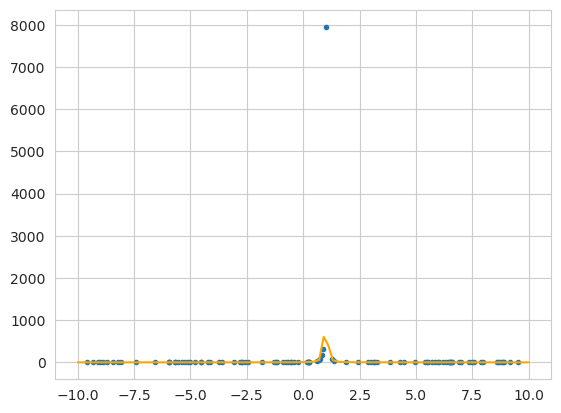

a: [5.], x_0:[1.]


In [194]:
a = 5
x_o = 1
err= 1
delta = 0.00001
%matplotlib inline
num_points = 100


def line_model(x, params):
    a, x_o = params
    
    
    return a[:,None]/((x-x_o[:,None])**2 + delta)


def line_noisy(x, params):
    return line_model(x,params) + np.random.normal(0, np.sqrt(err), len(x))

xs = np.linspace(-10, 10, 100)

x_observed = np.random.uniform(-10,10,num_points)

x_observed = tf.cast(tf.constant(x_observed), tf.float32)
a = tf.cast(tf.constant([a]),tf.float32)
x_o = tf.cast(tf.constant([x_o]),tf.float32)
err = tf.cast(tf.constant(err), tf.float32)


y_observed = line_noisy(x_observed, (a, x_o))
y_observed = np.array(y_observed).flatten()
y_observed = tf.cast(tf.constant(y_observed),tf.float32)
    


xs = np.linspace(-10,10,100)
xs = tf.cast(tf.constant(xs), tf.float32)
plt.plot(x_observed, y_observed, '.')
plt.errorbar(x_observed, y_observed, yerr = err, marker = 's', fmt = 'None', ecolor = 'red', alpha = 0.3)
plt.plot(xs, tf.reshape(line_model(xs, (a, x_o)),(num_points)), color = 'orange')
plt.show()

print(f'a: {a}, x_0:{x_o}')

In [195]:
# @tf.function

tfb = tfp.bijectors
example = line_prior.sample(seed=0)
size = int(tf.size(tf.nest.flatten(example)))
pack_bij = tfb.Chain(
    [
        tfb.pack_sequence_as(example),
        tfb.Split(size),
        tfb.Reshape(event_shape_out=(-1,), event_shape_in=(size, -1)),
        tfb.Transpose(perm=(1,0)),
    ]
)
unconstraining_bij = line_prior.experimental_default_event_space_bijector()
bij = tfb.Chain([unconstraining_bij, pack_bij])

def log_prob( x_observed, y_observed,  z, svi=False):
        # if not svi:
        #     m,b = params[0], params[1]
        # else:
        #     m,b = params[:,0], params[:,1]
            
        x = bij.forward(z)
        m,b= x['a'], x['x_o']
     
        
            
        y_model = tf.reshape(line_model(x_observed, (m,b)), (num_points, -1))
        y_model = tf.reshape(y_model, (len(m), num_points))
        errs = tf.constant(err, shape=(len(m), num_points), dtype='float32')

        log_like = tfd.Independent(tfd.Normal(y_model, errs), reinterpreted_batch_ndims=None).log_prob(y_observed)


        # log_prior = line_prior.log_prob(dict(slope=m, y_intercept=b))
        log_prior = line_prior.log_prob(x) + unconstraining_bij.forward_log_det_jacobian(pack_bij.forward(z))

        return log_like + log_prior, tf.reduce_mean(((y_observed - y_model)/errs)**2, axis = None)

In [196]:
start = line_prior.sample(12)

In [197]:
# ms = tf.constant([1.0,2.0,3.0,4.0])
# bs = tf.constant([1.0,-3.0,2.0,4.0])

# test = line_prior.sample(12)
# test_t = tf.Variable(bij.inverse(test))

# lps, square_errs = log_prob(x_observed, y_observed, test_t)
# lps


In [198]:
class ModellingSequence():
    def __init__(self, x_observed, y_observed, prior):
        tfb = tfp.bijectors
        self.x_observed = x_observed
        self.y_observed = y_observed
        example = prior.sample(seed=0)
        size = int(tf.size(tf.nest.flatten(example)))
        self.pack_bij = tfb.Chain(
            [
                tfb.pack_sequence_as(example),
                tfb.Split(size),
                tfb.Reshape(event_shape_out=(-1,), event_shape_in=(size, -1)),
                tfb.Transpose(perm=(1,0)),
            ]
        )
        self.unconstraining_bij = prior.experimental_default_event_space_bijector()
        self.bij = tfb.Chain([self.unconstraining_bij, self.pack_bij])
        
        
        
    @tf.function
    def log_prob(self, x_observed, y_observed,  z, svi=False):
  
        x = self.bij.forward(z)
        # m,b,c = x['m'], x['b'], x['c']
        m,b = x['a'], x['x_o']
     
        
            
        # y_model = tf.reshape(line_model(x_observed, (m,b,c)), (num_points, -1))
        y_model = tf.reshape(line_model(x_observed, (m,b)), (num_points, -1))
        y_model = tf.reshape(y_model, (len(m), num_points))
        errs = tf.constant(err, shape=(len(m), num_points), dtype='float32')

        log_like = tfd.Independent(tfd.Normal(y_model, errs), reinterpreted_batch_ndims=None).log_prob(y_observed)


        # log_prior = line_prior.log_prob(dict(slope=m, y_intercept=b))
        log_prior = line_prior.log_prob(x) + self.unconstraining_bij.forward_log_det_jacobian(self.pack_bij.forward(z))

        return log_like + log_prior, tf.reduce_mean((((y_observed - y_model)**2)/errs), axis = 1)
        
    def MAP(self, optimizer, star=None, n_samples=500, num_steps=350, seed=0):
        tf.random.set_seed(seed)
        start = line_prior.sample(n_samples)
        # ms = start['slope']
        # bs = start['y_intercept']
        
        trial = tf.Variable(self.bij.inverse(start))
        
#         ms_train = tf.Variable(ms, trainable=True)
#         bs_train = tf.Variable(bs, trainable=True)
        
        @tf.function
        def train_step():
            with tf.GradientTape() as tape:
                log_probability, square_err = self.log_prob(self.x_observed, self.y_observed, z=trial)
                agg_loss = tf.reduce_mean(-log_probability / len(x_observed))
            gradients = tape.gradient(agg_loss, [trial])
            optimizer.apply_gradients(zip(gradients, [trial]))
            return square_err, log_probability
        chi2s = []
        lprobs = []

        with trange(num_steps) as pbar:
            for _ in pbar:
                square_err, lprob = train_step()
                chi2s.append(square_err)
                lprobs.append(lprob)
                pbar.set_description(f"Chi Squared: {(np.nanmin(square_err)):.4f}")
        return trial, chi2s, lprobs
    
    
    
    def SVI(self, optimizer, start, n_vi=250, init_scales=1e-3, num_steps=500, seed=2):
        tf.random.set_seed(seed)
        
        start = tf.squeeze(start)
        tf.print(start)
       
        
        
        
        scale = (
            np.ones(len(start)).astype(np.float32) * init_scales
            if np.size(init_scales) == 1
            else init_scales
        )
        
        
        q_z = tfd.MultivariateNormalTriL(
            loc = tf.Variable(start),
            scale_tril = tfp.util.TransformedVariable(
                np.diag(scale),
                tfp.bijectors.FillScaleTriL(diag_bijector=tfp.bijectors.Exp(), diag_shift=1e-6),
                name="stddev",
            ),
        )
        
        
        

        
        losses = tfp.vi.fit_surrogate_posterior(
            lambda z: self.log_prob(self.x_observed, self.y_observed, z, svi=True)[0],
            surrogate_posterior=q_z,
            sample_size=n_vi,
            optimizer=optimizer,
            num_steps=num_steps,
        )
        
        return q_z, losses
    
    
    def HMC(self,
            q_z,
            init_eps=0.3,
            init_l=3,
            n_hmc=50,
            num_burnin_steps=250,
            num_results=750,
            max_leapfrog_steps=30,
            seed=3,
           ):
        def tqdm_progress_bar_fn(num_steps):
            return iter(tqdm(range(num_steps), desc="", leave=True))
        
        tf.random.set_seed(seed)
        
        mc_start = q_z.sample(n_hmc)
        cov_estimate = q_z.covariance()
        
        momentum_distribution = (
            tfp.experimental.distributions.MultivariateNormalPrecisionFactorLinearOperator(
                precision_factor=tf.linalg.LinearOperatorLowerTriangular(
                    tf.linalg.cholesky(cov_estimate),
                ),
                precision=tf.linalg.LinearOperatorFullMatrix(cov_estimate),
            )
        )
        
        # @tf.function
        def run_chain():
            num_adaptation_steps = int(num_burnin_steps * 0.8)
            start = tf.identity(mc_start)
            
         
            mc_kernel = tfp.experimental.mcmc.PreconditionedHamiltonianMonteCarlo(
                target_log_prob_fn=lambda z: self.log_prob(self.x_observed, self.y_observed, z, svi=True)[0],
                momentum_distribution=momentum_distribution,
                step_size=init_eps,
                num_leapfrog_steps=init_l,
            )
           
            mc_kernel = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(
                mc_kernel,
                num_adaptation_steps=num_adaptation_steps,
                max_leapfrog_steps=max_leapfrog_steps,
            )
            
                
            mc_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
                inner_kernel=mc_kernel, num_adaptation_steps=num_adaptation_steps
            )
            
            pbar = tfp.experimental.mcmc.ProgressBarReducer(
                num_results + num_burnin_steps - 1, progress_bar_fn=tqdm_progress_bar_fn
            )
            
            mc_kernel = tfp.experimental.mcmc.WithReductions(mc_kernel, pbar)
            
            
            return tfp.mcmc.sample_chain(
                num_results=num_results,
                num_burnin_steps=num_burnin_steps,
                current_state=start,
                kernel=mc_kernel,
                seed=seed,
            )

        return run_chain()

In [199]:
fitter = ModellingSequence(x_observed, y_observed, line_prior)


schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-1, 500, 1e-3)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=500, num_steps=500, seed=0)

  0%|          | 0/500 [00:00<?, ?it/s]

In [200]:
# start = line_prior.sample(2)
# trial = tf.Variable(fitter.bij.inverse(start))

# fitter.bij.forward(trial)['a']

In [201]:
start

{'x_o': <tf.Tensor: shape=(12,), dtype=float32, numpy=
 array([ 1.8734932,  3.0455732, -5.098958 ,  7.1635056,  9.834904 ,
         5.294113 ,  2.4299412, -7.173307 ,  6.6524773, -9.753032 ,
        -2.074399 , -8.385155 ], dtype=float32)>,
 'a': <tf.Tensor: shape=(12,), dtype=float32, numpy=
 array([ 3.617239  ,  2.6347046 ,  3.7518072 ,  0.35746384, -3.3174253 ,
         4.00222   , -7.8128004 ,  2.6262665 , -7.806015  ,  3.7023716 ,
         2.8013878 , -0.11391163], dtype=float32)>}

In [202]:
trial, chi2s, lprobs = MAP
lps = fitter.log_prob(x_observed, y_observed, trial)[0]
best_idx = tf.argmax(lps).numpy()
# MAP_m = ms_train[best_idx].numpy()
# MAP_b = bs_train[best_idx].numpy()



In [203]:
start =  trial[tf.argmax(lps).numpy()]

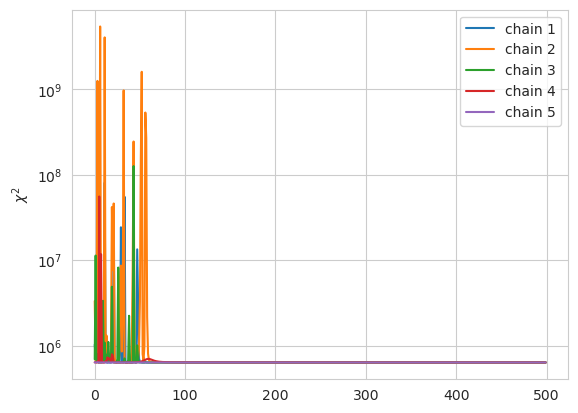

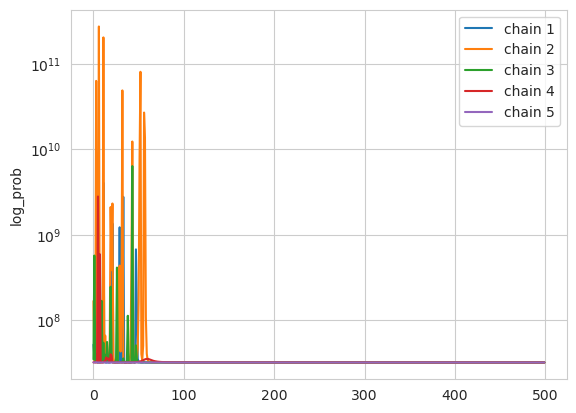

In [204]:
for i in range(5): 
    plt.plot(np.array(chi2s)[:,i], label=f'chain {i+1}')
    plt.ylabel(r'$\chi^2$')
plt.yscale('log')
plt.savefig('chi2s')
plt.legend()
plt.show()


for i in range(5): 
    plt.plot(-np.array(lprobs)[:,i], label=f'chain {i+1}')
    plt.ylabel('log_prob')
plt.yscale('log')
plt.savefig('log_prob')
plt.legend()
plt.show()


In [205]:
# type(line_prior.sample(2)['a'])

In [206]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 500, 4e-3, 2)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
q_z, losses = fitter.SVI(optimizer=optimizer, start=start, num_steps=1500, n_vi=300)

[0.37471661 0.208712772]


In [207]:
# truth = [[{'m':2, 'b': 3, 'c':4}]]
truth = [[{'a':5, 'x_o': 1}]]


# get_samples = lambda x: tf.convert_to_tensor([
#     x[0][0]['m'],
#     x[0][0]['b'],
#     x[0][0]['c'],
# ])

get_samples = lambda x: tf.convert_to_tensor([
    x[0][0]['a'],
    x[0][0]['x_o'],
])


markers = get_samples(truth)


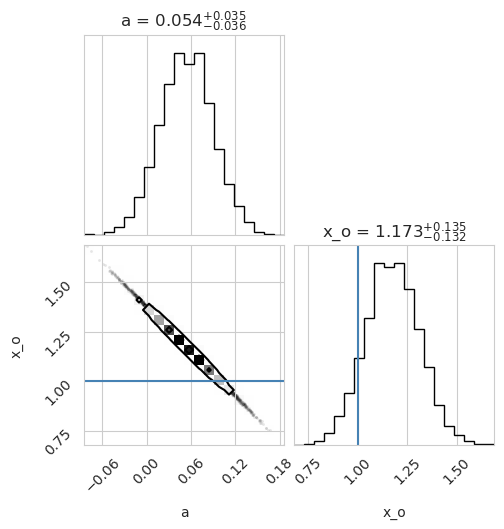

In [208]:
svi_samples = q_z.sample(5000)

svi_samples_physical = get_samples([[fitter.bij.forward(svi_samples)]]).numpy()

# corner(svi_samples_physical.reshape(3,-1).T, show_titles=True, title_fmt='.3f',
#       labels=['m', 'b', 'c'], truths=markers)

corner(svi_samples_physical.reshape(2,-1).T, show_titles=True, title_fmt='.3f',
      labels=['a', 'x_o'], truths=markers).savefig('svi')

plt.show()

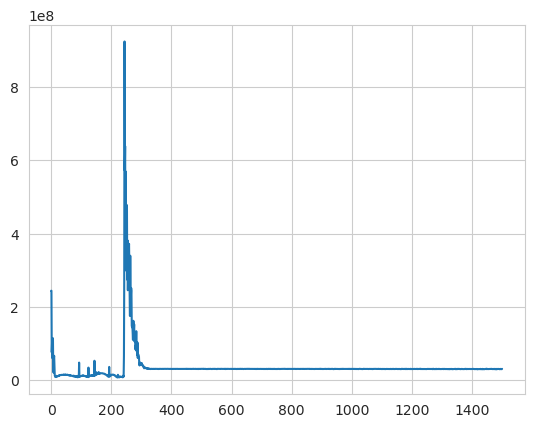

In [209]:
plt.plot(losses)
plt.savefig('losses')

In [210]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

  0%|          | 0/999 [00:00<?, ?it/s]

/home/tamar/anaconda3/lib/python3.11/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [211]:
phys_samples =get_samples([[fitter.bij.forward(samples)]]).numpy()

In [212]:
Rhat = tfp.mcmc.potential_scale_reduction(samples).numpy()
ESS = tfp.mcmc.effective_sample_size(samples, cross_chain_dims=1).numpy()
print(Rhat, ESS)

[2.3814252e+09 3.3716782e+09] [49.999996 49.999996]


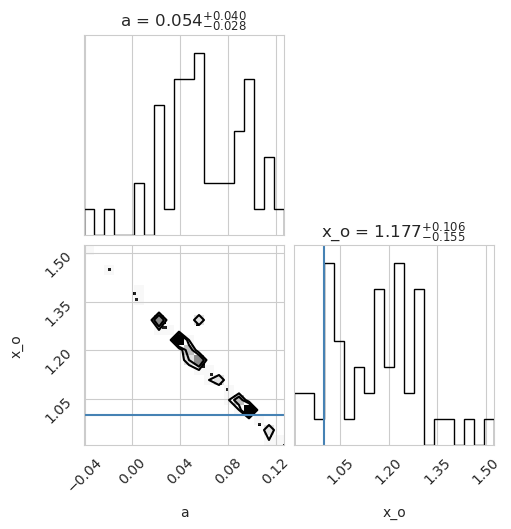

In [213]:
# corner(phys_samples.reshape((3,-1)).T, truths=markers,
#       show_titles=True, title_fmt='.3f',
#       labels=['m', 'b', 'c'])

corner(phys_samples.reshape(2,-1).T, truths=markers,
      show_titles=True, title_fmt='.3f',
      labels=['a', 'x_o'])

plt.savefig('corner')
plt.show()

In [214]:
sampp = phys_samples.reshape(2,-1).T
test = dict(a=sampp[:,0], x_o=sampp[:,1])
that = fitter.bij.inverse(test)

logprobs, squarer = fitter.log_prob(x_observed, y_observed, that)

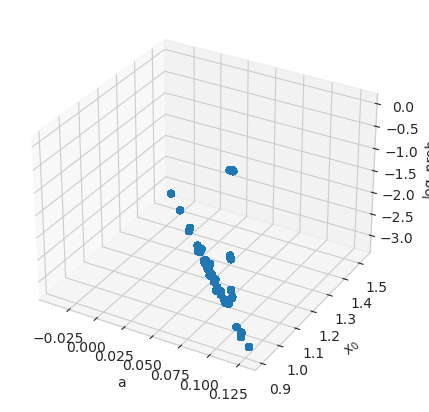

In [215]:
%matplotlib inline
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection='3d')
ax.scatter(sampp[:,0], sampp[:,1], logprobs)
ax.set_xlabel('a')
ax.set_ylabel('$x_0$')
ax.set_zlabel('log_prob')
plt.savefig('posterior surface')
plt.show()

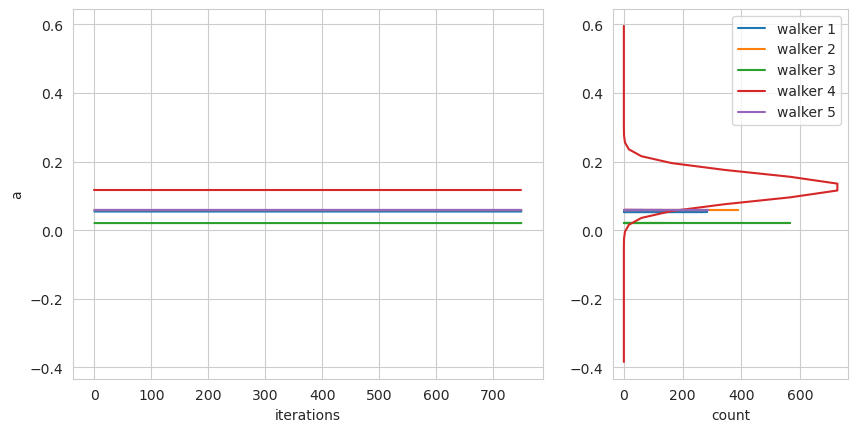

In [216]:
from matplotlib import gridspec
from scipy import signal

kernel = signal.windows.gaussian(20, 2)

fig = plt.figure()
# ax2.y_label('slope')
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[2, 1], wspace=0.2,
                         hspace=0.5, height_ratios=[2])

ax2 = fig.add_subplot(spec[0])

ax1 = fig.add_subplot(spec[1], sharey=ax2)
for i in range(5):
    hist = np.histogram(phys_samples[0,:,i], 50)
    filtered = np.convolve(hist[0], kernel, mode='same')
    
    ax1.plot(filtered, hist[1][:-1], label=f'walker {i+1}')
    ax2.plot(phys_samples[0,:,i])
    # ax1.get_yaxis().set_ticklabels([])
    

ax2.figure.set_figwidth(10)
ax2.set_ylabel('a')
ax2.set_xlabel('iterations')

ax1.set_xlabel('count')



plt.legend()
    
plt.savefig('trace')

plt.show()

# plt.plot(samples[:,:,1])
# plt.ylabel('y_intercept')
# plt.show()



In [217]:
best_a = np.median(phys_samples.reshape(2,-1).T[:,0])
best_x_o = np.median(phys_samples.reshape(2,-1).T[:,1])
# best_c = np.median(phys_samples.reshape(3, -1).T[:,2])

best_a = tf.cast(tf.constant([best_a]),tf.float32)
best_x_o = tf.cast(tf.constant([best_x_o]),tf.float32)
# best_c = tf.cast(tf.constant([best_c]), tf.float32)

x_test = tf.cast(tf.constant(np.linspace(-10,10, 100)), tf.float32)

y_test = line_model(x_test, (best_a, best_x_o))

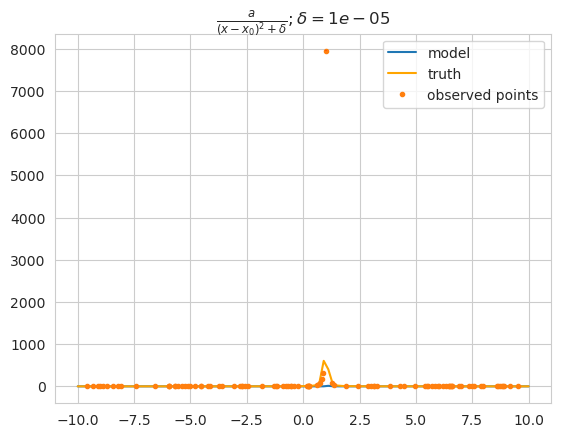

In [218]:
plt.plot(x_test, tf.squeeze(y_test), label='model')
plt.plot(xs, tf.reshape(line_model(xs, (a,x_o)),(num_points)), color = 'orange', label='truth')
plt.plot(x_observed, y_observed, '.', label='observed points')
plt.errorbar(x_observed, y_observed, yerr = err, marker = 's', fmt = 'None', ecolor = 'red', alpha = 0.3)

plt.title(r'$\frac{{a}}{{(x-x_0)^2 + \delta}}; \delta={}$'.format(delta))
plt.legend()
plt.savefig('modvtru')
plt.show()

# No Bijectors